In [93]:
import os
import sys
import numpy as np
from tqdm import tqdm

In [94]:
# 1: load models
# 2: load associtaed pysr model (same but simplifies to get the values right before the last MLP)
# save into csv files

In [95]:
PATH = "/master/code/experimental/pysr/apply_model_pySr"

In [96]:
print(os.path.exists(PATH))

True


In [97]:
def getModelName(key):

    name = ''

    #if 'simplest' in key:
    #    name = name + 'simplest'
    
    name = name + 'simplest'

    ## other possibilities

    if 'no-dropout' in key:
        name = name + '_no-dropout'
    else:
        name = name + '_dropout'

    if 'no-encoder' in key:
        name = name + '_no-encoder'
    else:
        name = name + '_encoder'

    if 'relu' in key:
        name = name + '-relu'

    return name


def loadModel(modelName:str, inputShape:int = 8, edges_shape = 5, path = None):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    model = loadFun.loadNetwork(inputShape, edges_shape)

    return model


def findModels(path):
    pathLists = []
    for root, dirs, files in tqdm(os.walk(path)):
            for file in files:
                
                if file.endswith('.pt'):
                    pathLists.append(os.path.join(root, file))


    return pathLists

In [98]:
modelsList = findModels(PATH)

for std_path in modelsList:
    modelName = getModelName(std_path)
    print(modelName)

    modelName = modelName + '-pysr'

1it [00:00, 112.73it/s]

simplest_no-dropout_no-encoder
simplest_no-dropout_no-encoder


In [113]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing

LATENT_SHAPE = 128

# GNN related parameters
EDGES_SHAPE = 5
MESSAGE_SHAPE = 128
HIDDEN_NN_SHAPE = 128

# output
OUTPUT_SHAPE = 2

class MLP(nn.Module):
    """ 
    linearly growing size
    """
    def __init__(self, inputShape:int, outputShape:int, dropout:float = 0.3):
        super(MLP, self).__init__()

        self.inputShape = inputShape
        self.outputShape = outputShape

        self.delta = (inputShape - outputShape) // 3
        dim1 = inputShape - self.delta
        dim2 = dim1 - self.delta

        self.mlp = nn.Sequential(
            nn.Linear(inputShape, dim1),
            nn.LeakyReLU(),
            nn.Linear(dim1, dim2),
            # nn.ELU(),
            nn.LeakyReLU(),
            nn.Linear(dim2, outputShape),
        )
        
        self.init_weights()
    
    def forward(self, x):
        x = self.mlp(x)
        return x
    
    def init_weights(self):
        for layer in self.mlp.children():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
                # nn.init.xavier_normal_(layer.weight)
                # nn.init.zeros_(layer.bias)
                layer.bias.data.fill_(0.)

class MLP2(nn.Module):
    """
    constant size
    """
    def __init__(self, inputShape:int, latentShape:int, outputShape:int, dropout:float = 0.3):
        super(MLP2, self).__init__()

        self.inputShape = inputShape
        self.latentShape = latentShape
        self.outputShape = outputShape

        self.mlp = nn.Sequential(
            nn.Linear(inputShape, latentShape),
            nn.LeakyReLU(),
            nn.Linear(latentShape, latentShape),
            nn.LeakyReLU(),
            nn.Linear(latentShape, outputShape),
        )
        
        self.init_weights()
    
    def forward(self, x):
        x = self.mlp(x)
        return x
    
    def init_weights(self):
        for layer in self.mlp.children():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
                # nn.init.xavier_normal_(layer.weight)
                # nn.init.zeros_(layer.bias)
                layer.bias.data.fill_(0.)

class GN_edge(MessagePassing):
    """ 
    Message passing neural network in which the message passing
    only considers the edges features
    """
    def __init__(self, inputShape:int, messageShape:int, outputShape:int, shapeEdges:int = 7, hiddenShape:int=64, aggr:str='add', predBool=True):
        super(GN_edge, self).__init__(aggr=aggr)

        self.inputShape = inputShape
        self.messageShape = messageShape
        self.outputShape = outputShape
        self.hiddenShape = hiddenShape
        
        self.messageMLP = MLP2(shapeEdges, hiddenShape, messageShape)
        self.reluLayer = nn.ReLU()
        self.norm = torch.nn.LayerNorm(messageShape + inputShape)
        
        self.updateMLP = MLP(messageShape + inputShape, outputShape)

        self.predBool = predBool
    
    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_attr: torch.tensor):
        # Propagate messages
        out, xVal = self.propagate(edge_index, size=(x.size(0), x.size(0)), edge_attr=edge_attr, x=x)
        
        return out, xVal
      
    def message(self, x_i: torch.tensor, x_j: torch.tensor, edge_attr: torch.tensor):
        """ 
        Performs the message passing in the graph neural network
        
        Args:
        -----
        - `x_i`: tensor associated to node i
        - `x_j`: tensor associated to node j
        """
        y = self.messageMLP(edge_attr)
        return y
    
    def update(self, aggr_out: torch.tensor, x: torch.tensor):
        """ 
        Function to update all the nodes after the aggregation
        
        Args:
        -----
        - `aggr_out`: result after the aggregation [# Nodes, messageShape]
        - `x`: current node [1, inputShape]
        """

        xVal = self.norm(torch.cat([x, aggr_out], dim=-1))

        if self.predBool:
            return self.updateMLP(xVal), xVal 
        else:
            return self.updateMLP(xVal)

class Simplest(nn.Module):
    def __init__(self, inShape:int, latentShape:int, outShape:int, messageShape:int, edge_shape:int = EDGES_SHAPE, hiddenGN:int = 128, predBool=False):
        """ 
        Neural network to combine everything
        
        Args:
        -----
        - `inShape`: shape of the input vector
        - `latentShape`: shape of the latent space
        - `outShape`: shape of the output vector
        - `messageShape`: shape of the message in the GN
        - `hiddenGN`: shape of the hidden layers in the MLP of the GN
        """
        super().__init__()
        
        self.inShape = inShape
        self.latentShape = latentShape
        self.outShape = outShape
        
        # GNN
        self.GNN = GN_edge(inShape, messageShape, outShape, edge_shape, hiddenGN, predBool=predBool)
        
    def forward(self, graph):
        """ 
        Args:
        -----
        - `x`: value for the nodes [# Nodes, #Timesteps x inShape]
        - `edge_index`
        - `edge_attr`
        """
        x = graph.x
        edge_index = graph.edge_index
        edge_attr = graph.edge_attr
        
        # gnn part
        y, intermediate = self.GNN(x, edge_index, edge_attr)  # [#Nodes, outShape]

        return y, intermediate

    def applyEnc(self, x):
        return x
    
    def L1Reg(self, graph):
        atr = graph.edge_attr

        messages = self.GNN.message(None, None, atr)

        loss = 0.01 * torch.sum(torch.abs(messages)) / graph.edge_index[0, :].shape[0]

        return loss
    
    def getMessage(self, x, y, a):
        return self.GNN.message(None, None, a)
    
    def getEncoding(self, x):
        return self.applyEnc(x)

def loadNetwork(inputShape, edge_shape=EDGES_SHAPE):
    print('>>>> loading simplest')
    print('INFO >>> relu end of message MLP')
    print('INFO >>> with NO encoder')
    print('INFO >>> with NO dropout')
    print('INFO >>> PYSR mode')
    net = Simplest(inputShape, LATENT_SHAPE, OUTPUT_SHAPE, MESSAGE_SHAPE, edge_shape, HIDDEN_NN_SHAPE)

    return net


In [114]:
std_dict = torch.load(modelsList[0])

In [115]:
net = Simplest(8, LATENT_SHAPE, OUTPUT_SHAPE, MESSAGE_SHAPE,5, HIDDEN_NN_SHAPE, predBool=True)

In [116]:
net.load_state_dict(std_dict)

<All keys matched successfully>

### Test

In [117]:
def path_link(path:str):
    sys.path.append(path)

path_link('master/code/lib')

In [118]:
import simulation_v2 as sim 
import features as ft


In [119]:
lim = 0.85 * 100

xPos = np.linspace(-lim, lim, 10)
yPos = np.linspace(-lim, lim, 10)
gridX, gridY = np.meshgrid(xPos, yPos)
delta = np.random.uniform(0, 7, gridX.shape + (2,))

gridX2 = gridX + delta[:, :, 0]
gridY2 = gridY + delta[:, :, 1]

pos = np.stack([gridX.ravel(), gridY.ravel()], axis=1)
pos_perturbed = np.stack([gridX2.ravel(), gridY2.ravel()], axis=1)

pos = np.concatenate([pos, pos_perturbed], axis=0)

angles = np.random.rand(pos.shape[0]) * 2 * np.pi

In [120]:
# generate a simulation
data = sim.compute_main(200, (60, 3.5, 70, 0.5), 120, T = 1000, initialization = (pos, angles), dt = 0.001)[0]
#data = sim.compute_main(100, (60, 3.5, 70, 0.5), 120, T = 1000, dt = 0.001)[0]

# get speeds
x, y, attr, inds = ft.processSimulation(data)

v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:09<00:00, 109.74it/s]


In [121]:
from torch_geometric.data import Data
from norm import normalizeGraph

g = Data(x = x[0][:, 2:], y = y[0], edge_attr = attr[0], edge_index = inds[0])

In [122]:
g = normalizeGraph(g)
y = net(g)

In [123]:
print(y[0].shape)

torch.Size([200, 2])


In [124]:
print(y[1].shape)

torch.Size([200, 136])


In [ ]:
print()

In [127]:
v =np.std(y[1][:, :128].cpu().detach().numpy(), axis=0)

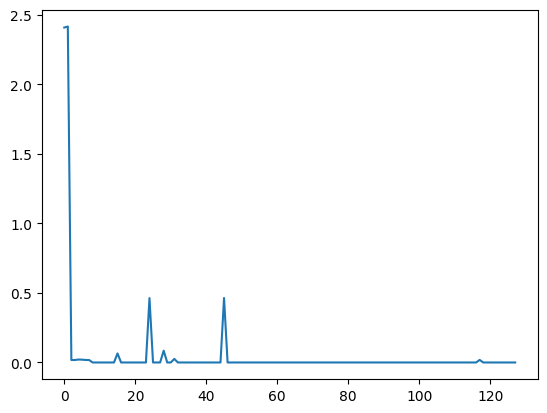

In [128]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(v)
plt.show()

In [ ]:
print()